## loading package

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_4dim, fgot_tol, align
from FGOT import metrics as mt

## load data

In [4]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/"
ATAC_data = pd.read_csv(data_path+'feature_250kb_ATAC_normalized.txt', sep='\t', index_col=0)
RNA_data = pd.read_csv(data_path+'feature_selected_RNA_normalized.txt', sep='\t', index_col=0)

RNA_cluster = pd.read_csv(data_path+'label.txt', sep='\t').rename(columns={'Unnamed: 0': 'cell', 'metas': 'cluster'})
ATAC_cluster = RNA_cluster.copy()

In [5]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (3197, 7835)  X2 =  (3197, 215)
Dimensions of basic_labels are:  basic_labels1 =  (3197,)  basic_labels2 =  (3197,)


## compute feature relationship

In [ ]:
promoters = pd.read_csv(data_path+'hg38.promoter.regions.txt', sep = '\t')
promoters.head()

In [ ]:
feature_matrix = pre.prior_feature_graph(promoters, gene_names, peak_names)
feature_matrix = feature_matrix.T

## compute cost

wnn to calculate cost

In [9]:
wnn = pd.read_csv(data_path+'PBMC_wnn.txt', sep='\t', index_col=0)
wnn

,Agg_1,Agg_2,Agg_3,Agg_4,Agg_5,Agg_6,Agg_7,Agg_8,Agg_9,Agg_10,...,Agg_3192,Agg_3193,Agg_3194,Agg_3195,Agg_3196,Agg_3197,Agg_3198,Agg_3199,Agg_3200,Agg_3201
Agg_1,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_2,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_3,0.0,0.0,1.000000,0.176471,0.0,0.0,0.000000,0.000000,0.081081,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_4,0.0,0.0,0.176471,1.000000,0.0,0.0,0.000000,0.000000,0.379310,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_5,0.0,0.0,0.000000,0.000000,1.0,0.0,0.111111,0.176471,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agg_3197,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.538462,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.212121,0.000000
Agg_3198,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.176471,0.081081,0.212121,0.000000,1.000000,0.379310,0.000000,0.176471
Agg_3199,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.250000,0.000000,0.428571,0.142857,0.538462,0.000000,0.379310,1.000000,0.000000,0.481481
Agg_3200,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.176471,0.142857,0.000000,0.250000,0.000000,0.212121,0.000000,0.000000,1.000000,0.000000


In [ ]:
cost = np.array(np.exp(1 - wnn))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

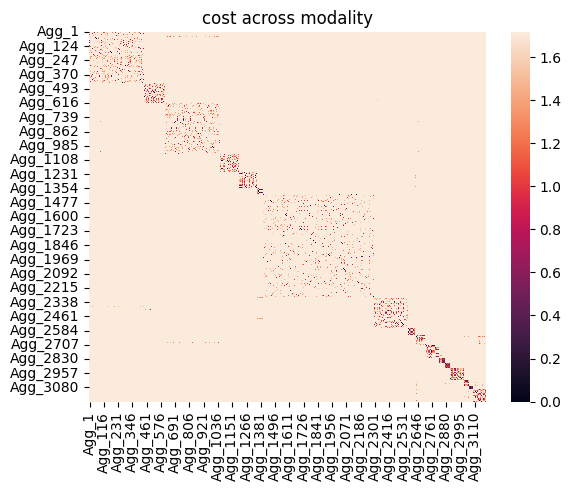

In [10]:
sns.heatmap(cost)
pl.title('cost across modality')

## scale

In [11]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport

In [ ]:
P_4dim = fgot_sparse_4dim(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, pair = True, device='cuda:4', eps_p = 1e-1, rho=10)

In [18]:
P = fgot_tol(P_4dim)
P.shape

100%|██████████| 9115/9115 [04:02<00:00, 37.54it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

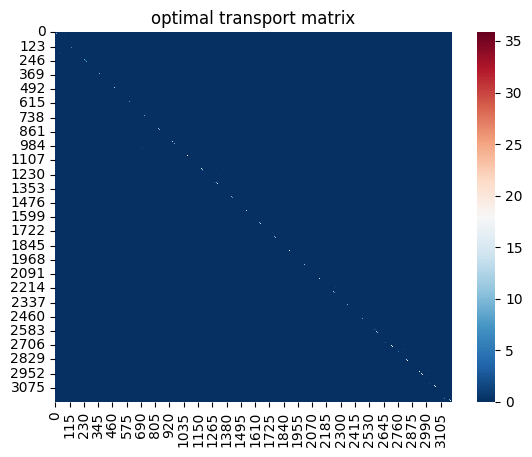

In [19]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [13]:
X1_aligned, X2_aligned = align(X1, X2, P, X2Y=False)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

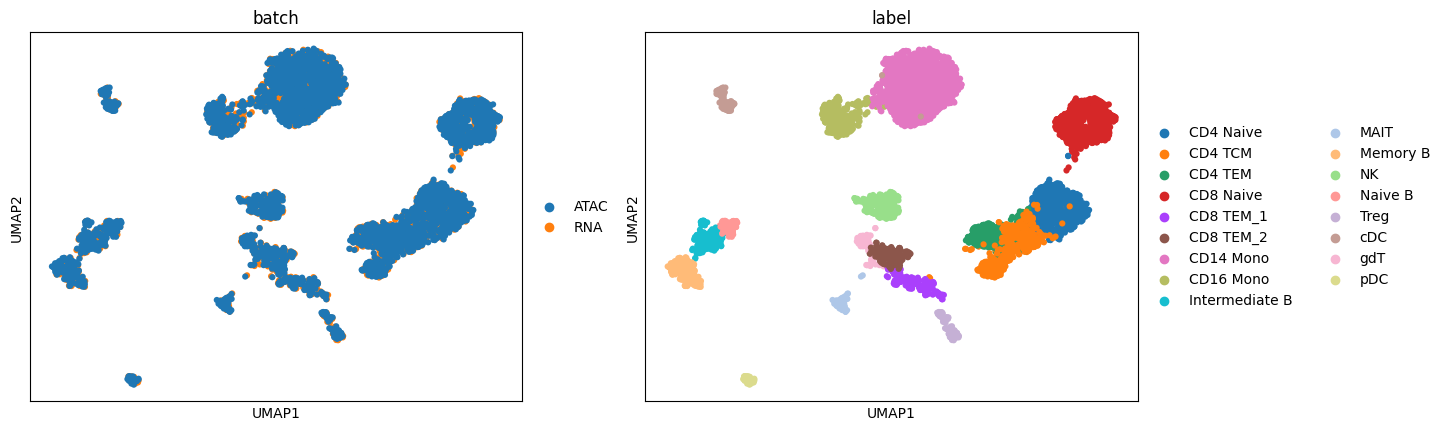

In [30]:
data_aligned = np.concatenate((X1_aligned,X2_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80)